
✅ 完整的综合评估报告已成功保存到文件: comprehensive_analysis_report_with_change.csv

--- 综合评估报告预览 ---
文件名          全局共享_NSE  全局共享_洪量相误(%) 全局共享_洪峰相误(%) 所属类别 特征单位线_NSE 特征单位线_洪量相误(%) 特征单位线_洪峰相误(%) NSE变化情况
20070811.csv    0.5494   16.14        17.58      良好组     0.1179   40.75         5.16        降低     
19920901.csv    0.5824   52.29        15.97      良好组     0.1528   84.78         7.79        降低     
20040803.csv    0.7288    3.70        29.67      良好组     0.2461   25.19        69.70        降低     
19980809.csv    0.8601   12.02        12.66      良好组     0.3319   36.86        46.65        降低     
19950817.csv    0.6282   18.37         5.68      良好组     0.3362    0.61        38.75        降低     
20010816.csv    0.7213   15.06         3.80      良好组     0.3856   38.91        35.36        降低     
20060731.csv    0.7702    2.19         0.49      良好组     0.4798   18.87        27.82        降低     
19870826.csv    0.8714   16.44        16.59      良好组     0.4813   40.85        53.26        降低     
19860731.csv  

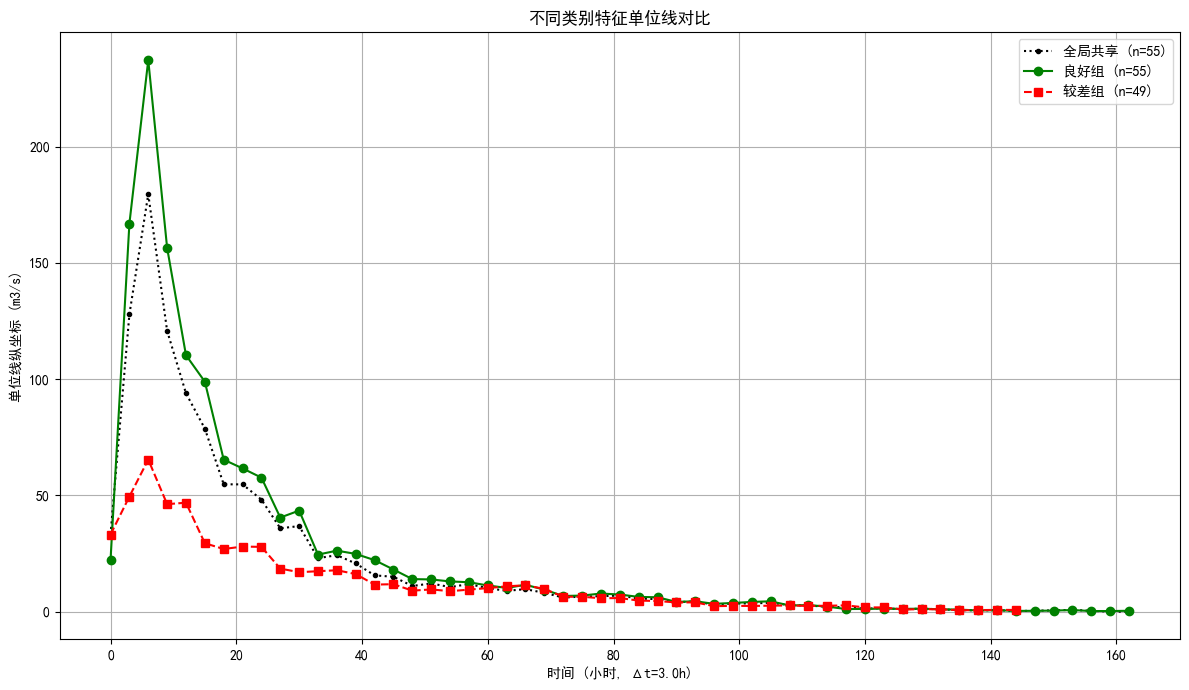

In [11]:
# ... (所有函数定义和第一、二、三阶段的优化代码保持不变) ...

# ==============================================================================
# --- 第四阶段：整合所有结果并输出到CSV文件 ---
# ==============================================================================
final_report_data = []

for event_data in all_events_processed_data:
    event_filename = os.path.basename(event_data["filepath"])
    
    # 计算全局共享单位线的指标
    metrics_shared = calculate_metrics_for_event(event_data, U_optimized_shared)
    
    # 判断类别并计算特征单位线的指标
    category_of_event = "未知"
    metrics_characteristic = {"NSE": np.nan, "洪量相误(%)": np.nan, "洪峰相误(%)": np.nan}
    
    # 使用 a set for faster lookup
    good_fit_filenames = {os.path.basename(d["filepath"]) for d in good_fit_events_data}
    poor_fit_filenames = {os.path.basename(d["filepath"]) for d in poor_fit_events_data}

    if event_filename in good_fit_filenames:
        category_of_event = "良好组"
        metrics_characteristic = calculate_metrics_for_event(event_data, U_optimized_goodfit)
    elif event_filename in poor_fit_filenames:
        category_of_event = "较差组"
        metrics_characteristic = calculate_metrics_for_event(event_data, U_optimized_poorfit)
        
    # --- 新增：计算NSE变化情况 ---
    nse_change_status = "无变化" # 默认值
    nse_shared = metrics_shared["NSE"]
    nse_char = metrics_characteristic["NSE"]
    
    if pd.notna(nse_shared) and pd.notna(nse_char) and np.isfinite(nse_shared) and np.isfinite(nse_char):
        if nse_char > nse_shared:
            nse_change_status = "上升"
        elif nse_char < nse_shared:
            nse_change_status = "降低"
        else:
            nse_change_status = "持平"
            
    final_report_data.append({
        "文件名": event_filename,
        "全局共享_NSE": nse_shared,
        "全局共享_洪量相误(%)": metrics_shared["洪量相误(%)"],
        "全局共享_洪峰相误(%)": metrics_shared["洪峰相误(%)"],
        "所属类别": category_of_event,
        "特征单位线_NSE": nse_char,
        "特征单位线_洪量相误(%)": metrics_characteristic["洪量相误(%)"],
        "特征单位线_洪峰相误(%)": metrics_characteristic["洪峰相误(%)"],
        "NSE变化情况": nse_change_status  # 添加新的一列
    })

# 转换为DataFrame并排序
report_df = pd.DataFrame(final_report_data)
# 按 "所属类别" 和 "特征单位线_NSE" 排序，可以更清晰地看出每个类别内的效果
report_df_sorted = report_df.sort_values(by=["所属类别", "特征单位线_NSE"], ascending=[True, True]).reset_index(drop=True)

# 保存到CSV文件
output_csv_path = "comprehensive_analysis_report_with_change.csv"
try:
    report_df_sorted.to_csv(output_csv_path, index=False, encoding='utf-8-sig', float_format='%.4f')
    print(f"\n✅ 完整的综合评估报告已成功保存到文件: {output_csv_path}")
except Exception as e:
    print(f"\n❌ 保存最终报告到文件失败: {e}")

# 在Notebook中打印预览
print("\n--- 综合评估报告预览 ---")
pd.set_option('display.max_rows', 100) # 增加预览行数以显示更多内容
pd.set_option('display.width', 200)   # 增加宽度
pd.set_option('display.colheader_justify', 'left') 
# 格式化DataFrame中的浮点数，便于阅读
formatted_df = report_df_sorted.copy()
for col in ["全局共享_NSE", "特征单位线_NSE"]:
    formatted_df[col] = formatted_df[col].map(lambda x: f'{x:.4f}' if pd.notna(x) and np.isfinite(x) else ('-Inf' if x == -np.inf else 'N/A'))
for col in ["全局共享_洪量相误(%)", "全局共享_洪峰相误(%)", "特征单位线_洪量相误(%)", "特征单位线_洪峰相误(%)"]:
    formatted_df[col] = formatted_df[col].map(lambda x: f'{x:.2f}' if pd.notna(x) else 'N/A')
print(formatted_df.to_string(index=False))
pd.reset_option('display.max_rows')
pd.reset_option('display.width')


# --- （可选）绘制单位线对比图 (与之前相同) ---
plt.figure(figsize=(12, 7))
if U_optimized_shared is not None: plt.plot(np.arange(len(U_optimized_shared))*DELTA_T_HOURS, U_optimized_shared, marker='.', linestyle=':', color='black', label=f'全局共享 (n={len(U_optimized_shared)})')
if U_optimized_goodfit is not None: plt.plot(np.arange(len(U_optimized_goodfit))*DELTA_T_HOURS, U_optimized_goodfit, marker='o', linestyle='-', color='green', label=f'良好组 (n={len(U_optimized_goodfit)})')
if U_optimized_poorfit is not None: plt.plot(np.arange(len(U_optimized_poorfit))*DELTA_T_HOURS, U_optimized_poorfit, marker='s', linestyle='--', color='red', label=f'较差组 (n={len(U_optimized_poorfit)})')
plt.title('不同类别特征单位线对比'); plt.xlabel(f'时间 (小时, Δt={DELTA_T_HOURS}h)'); plt.ylabel('单位线纵坐标 (m3/s)'); plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

###   五个水文特征分布图

找到 38 个CSV文件，将进行处理...

所有有效洪水事件的水文特征计算完成：
       洪峰流量         洪量            洪水历时        总净雨量        洪峰雨峰延迟   
count    38.000000  3.800000e+01   38.000000   38.000000  38.000000
mean   1204.437105  1.080729e+08  125.131579  100.801868   8.921053
std    1210.287280  9.353152e+07   36.629017   53.449922   8.863474
min      49.800000  2.665440e+06   57.000000    7.784000   0.000000
25%     556.000000  4.234140e+07   98.250000   65.360000   3.000000
50%     908.000000  9.908568e+07  120.000000   88.030000   6.000000
75%    1486.250000  1.317376e+08  168.000000  128.617500  12.000000
max    5284.000000  3.924547e+08  180.000000  232.290000  39.000000

--- 正在生成各水文特征的分布图 ---


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\3804218792.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=data, ax=ax, palette=palette, inner=None,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\3804218792.py:109: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


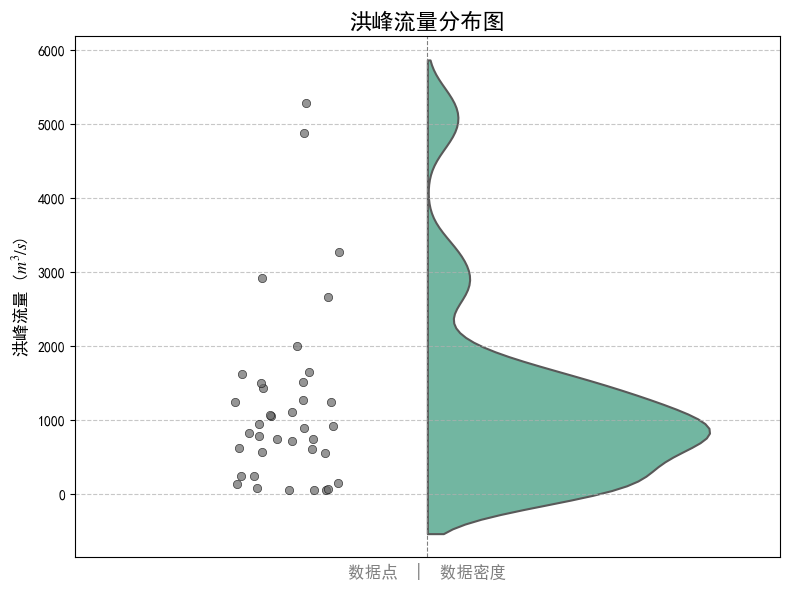

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\3804218792.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=data, ax=ax, palette=palette, inner=None,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\3804218792.py:109: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


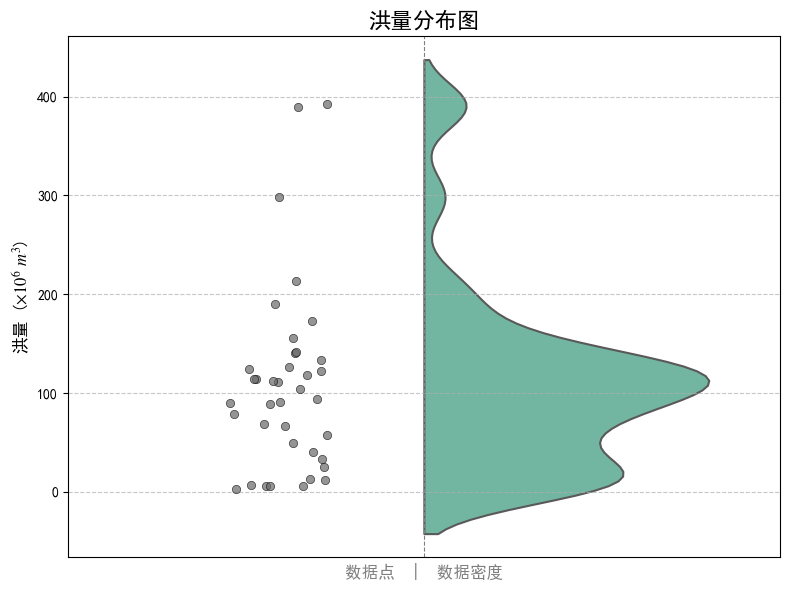

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\3804218792.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=data, ax=ax, palette=palette, inner=None,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\3804218792.py:109: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


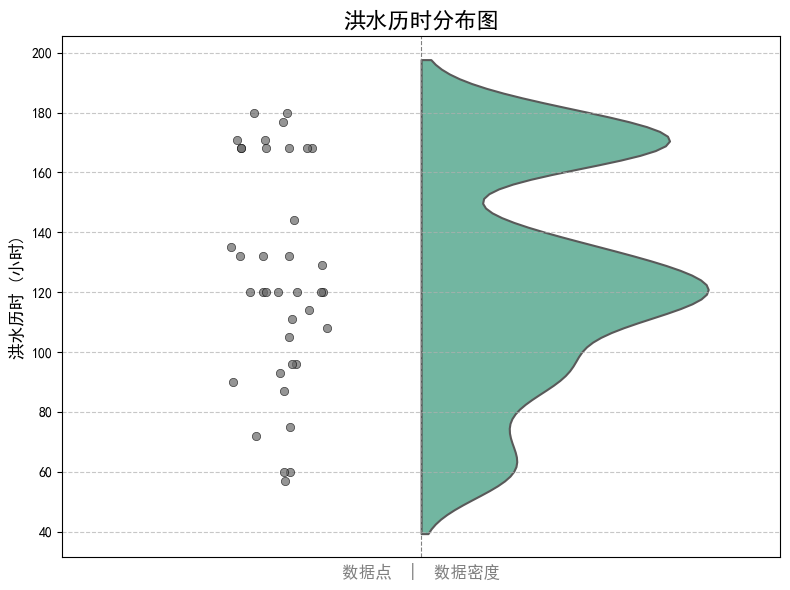

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\3804218792.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=data, ax=ax, palette=palette, inner=None,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\3804218792.py:109: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


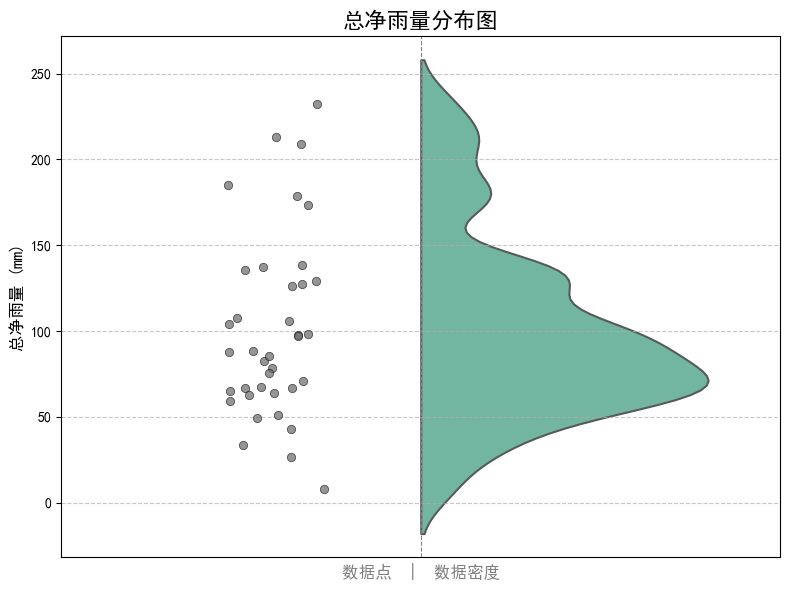

C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\3804218792.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=data, ax=ax, palette=palette, inner=None,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\3804218792.py:109: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


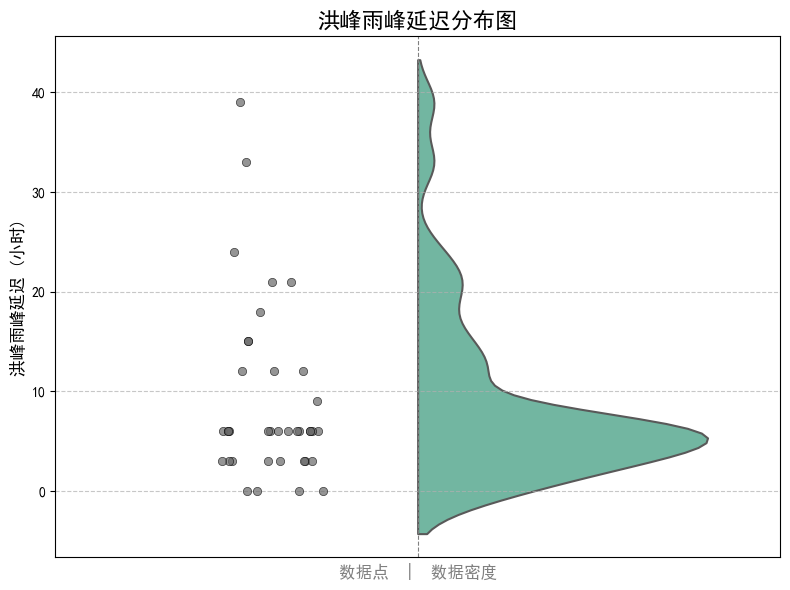

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")

# --- 全局常量 ---
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 主要功能函数：数据预处理和特征计算 (与之前版本相同) ---
def process_and_analyze_event(csv_filepath):
    """读取并处理单个洪水事件，并计算其关键水文特征。"""
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(csv_filepath, encoding=enc)
                break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None

    time_col = '时间'; net_rain_col = '泰森多边形面雨量'; direct_runoff_col = '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None

    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    
    if np.sum(net_rain) < 1e-6: return None
    runoff_indices = np.where(direct_runoff > 1e-6)[0]
    if len(runoff_indices) < 2: return None
    runoff_duration_hours = (runoff_indices[-1] - runoff_indices[0] + 1) * DELTA_T_HOURS
    
    peak_flow = np.max(direct_runoff)
    if peak_flow < 1e-6: return None
    t_peak_flow_idx = np.argmax(direct_runoff)
    
    runoff_volume_m3 = np.sum(direct_runoff) * delta_t_seconds
    total_net_rain = np.sum(net_rain)
    t_peak_rain_idx = np.argmax(net_rain)
    lag_time_hours = (t_peak_flow_idx - t_peak_rain_idx) * DELTA_T_HOURS

    return {
        "文件名": os.path.basename(csv_filepath),
        "洪峰流量": peak_flow,
        "洪量": runoff_volume_m3,
        "洪水历时": runoff_duration_hours,
        "总净雨量": total_net_rain,
        "洪峰雨峰延迟": lag_time_hours
    }

# --- 新增的绘图函数：雨云图 ---
def plot_raincloud(data, feature_name, unit, palette="Set2"):
    """
    绘制单个水文特征的分布图，通过位置调整将散点图和小提琴图分离开来。
    """
    fig, ax = plt.subplots(figsize=(8, 6))

    # --- 1. 绘制散点图 ---
    # 将其绘制在X轴的负半轴区域
    # `orient='h'` 先水平画，然后我们交换x,y轴
    # 或者直接用 stripplot 并手动设置x坐标
    # 为了简单，我们使用 jitter 在y轴上画，然后调整x轴范围
    sns.stripplot(y=data, ax=ax, 
                  jitter=0.2,
                  size=6,
                  alpha=0.7,
                  color="dimgray",
                  linewidth=0.5,
                  edgecolor='black')
    
    # 将所有散点的x坐标移动到负半轴
    for collection in ax.collections:
        # 获取每个点的x, y坐标
        x, y = collection.get_offsets().T
        # 将x坐标移动到-0.2附近，并增加一些随机性
        new_x = -0.2 + (np.random.rand(len(x)) * 0.15 - 0.075)
        collection.set_offsets(np.c_[new_x, y])


    # --- 2. 绘制小提琴图 ---
    # 将其绘制在X轴的正半轴区域
    sns.violinplot(y=data, ax=ax, palette=palette, inner=None, 
                   linewidth=1.5, bw_adjust=0.5)
    
    # 获取小提琴图的路径并只保留右半边，且起点在0
    for collection in ax.collections:
        # 通过颜色判断是否是小提琴图（散点图颜色是dimgray）
        # 这是一个小技巧，假设调色板不会包含dimgray
        if tuple(collection.get_facecolor()[0][:3]) != tuple(sns.color_palette(["dimgray"])[0]):
            path = collection.get_paths()[0]
            vertices = path.vertices
            # 将小提琴的左半边压到x=0这条线上
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    # --- 3. 美化和调整 ---
    # 设置X轴范围，并隐藏刻度
    ax.set_xlim(-0.5, 0.5) # 设置一个对称的X轴范围
    ax.set_xticks([])
    ax.set_xlabel("数据点  |  数据密度", fontsize=12, color='gray') # 更新X轴说明

    # 设置Y轴标签和图标题
    ax.set_ylabel(f"{feature_name} ({unit})", fontsize=12)
    ax.set_title(f'{feature_name}分布图', fontsize=16)
    
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 在x=0处画一条垂直分界线（可选）
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    
    plt.tight_layout()
    plt.show()


# --- 主程序 ---
if __name__ == "__main__":
    # 1. 定义数据源
    data_folder = "data_source/" 
    
    # 2. 获取所有CSV文件列表
    try:
        csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
        if not csv_files:
            print(f"错误: 在文件夹 '{data_folder}' 中未找到任何CSV文件。")
            exit()
        print(f"找到 {len(csv_files)} 个CSV文件，将进行处理...")
    except FileNotFoundError:
        print(f"错误: 文件夹 '{data_folder}' 不存在。请检查路径。")
        exit()

    # 3. 遍历所有文件，计算并收集所有事件的特征
    all_features_data = []
    for csv_file in csv_files:
        event_analysis_data = process_and_analyze_event(csv_file)
        if event_analysis_data:
            all_features_data.append(event_analysis_data)
    
    if not all_features_data:
        print("未能从任何事件中成功提取水文特征。")
        exit()
        
    # 4. 将结果转换为Pandas DataFrame，便于处理
    features_df = pd.DataFrame(all_features_data)
    print("\n所有有效洪水事件的水文特征计算完成：")
    print(features_df.describe()) # 打印基本统计信息

    # 5. 定义要绘制的特征及其标签和单位
    features_to_plot = {
    # --- 核心修改：使用LaTeX语法 ---
    "洪峰流量": r'$m^3/s$',
    "洪量": r'$\times 10^6\ m^3$', # 注意：数据本身需要除以1e6
    "洪水历时": "小时",
    "总净雨量": "mm",
    "洪峰雨峰延迟": "小时"
}

    # 6. 循环为每个特征绘图 (这部分调用逻辑不变)
    print("\n--- 正在生成各水文特征的分布图 ---")
    for feature, unit in features_to_plot.items():
        plot_data = features_df[feature].dropna()
    
        if feature == "洪量":
            plot_data = plot_data / 1e6
        
        if not plot_data.empty:
            plot_raincloud(plot_data, feature, unit)
        else:
            print(f"特征 '{feature}' 没有有效数据，无法绘图。")

### 雨云图添加最大值、最小值、平均值指标版本代码

找到 38 个CSV文件，将进行处理...

所有有效洪水事件的水文特征计算完成。

--- 正在生成各水文特征的分布图及统计值 ---

--- 特征: 洪峰流量 ---
  最大值: 5284.00
  最小值: 49.80
  平均值: 1204.44


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\2483006309.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=data, ax=ax, palette=palette, inner=None,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\2483006309.py:97: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


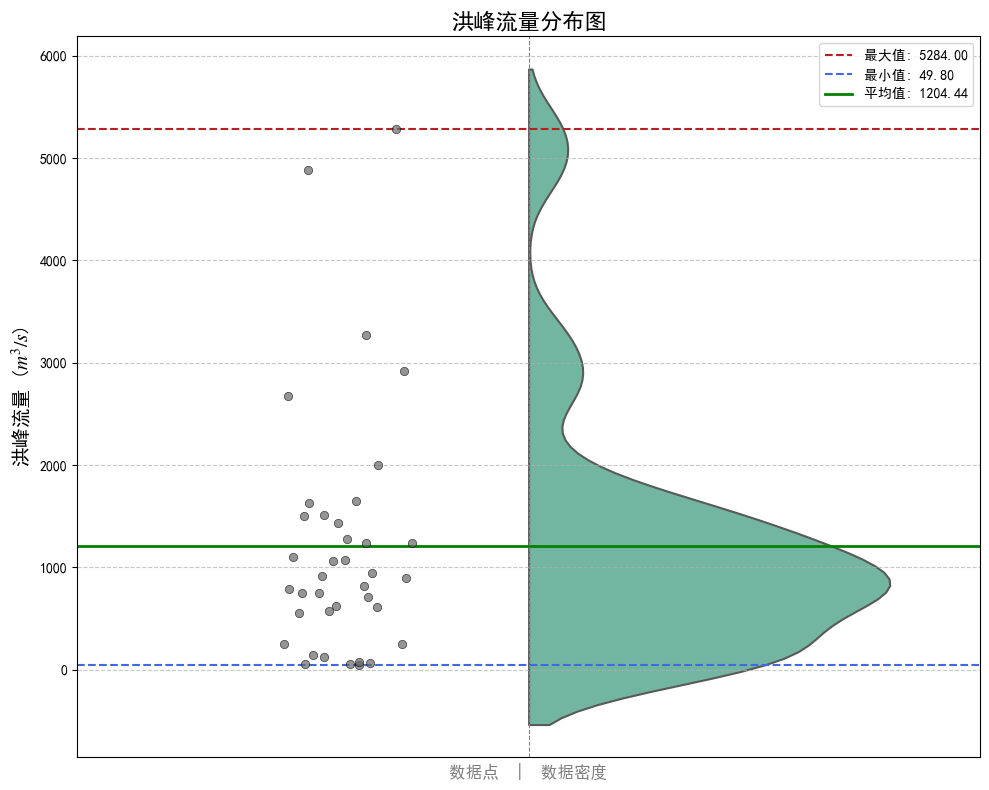


--- 特征: 洪量 ---
  最大值: 392.45
  最小值: 2.67
  平均值: 108.07


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\2483006309.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=data, ax=ax, palette=palette, inner=None,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\2483006309.py:97: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


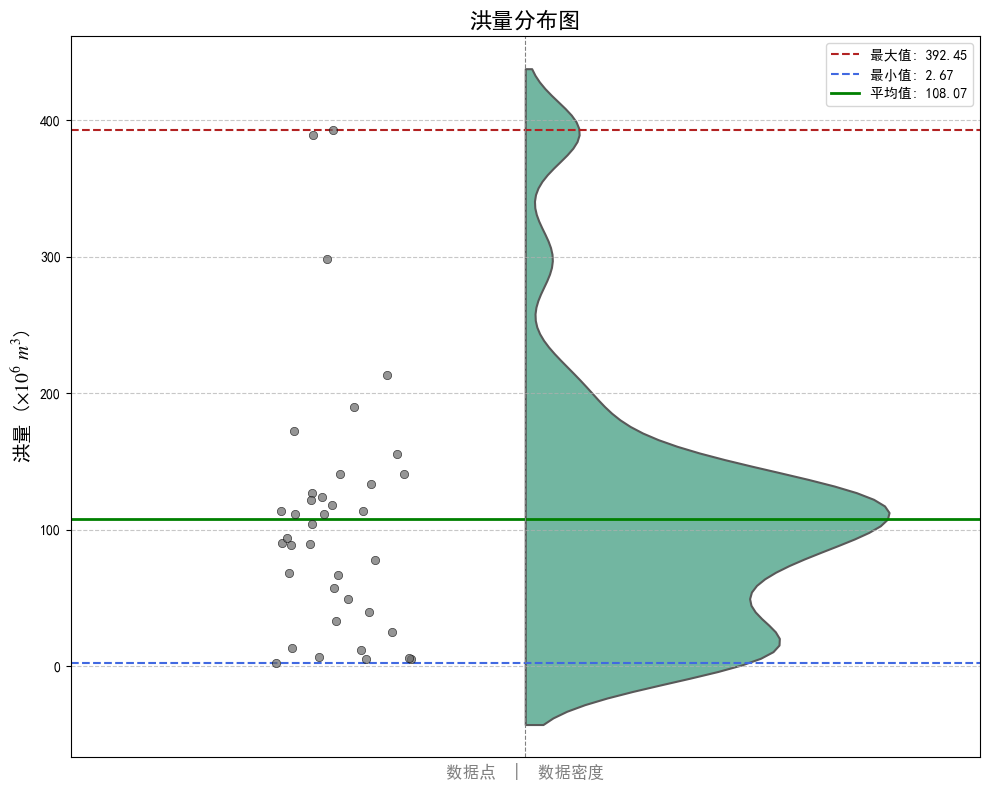


--- 特征: 洪水历时 ---
  最大值: 180.00
  最小值: 57.00
  平均值: 125.13


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\2483006309.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=data, ax=ax, palette=palette, inner=None,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\2483006309.py:97: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


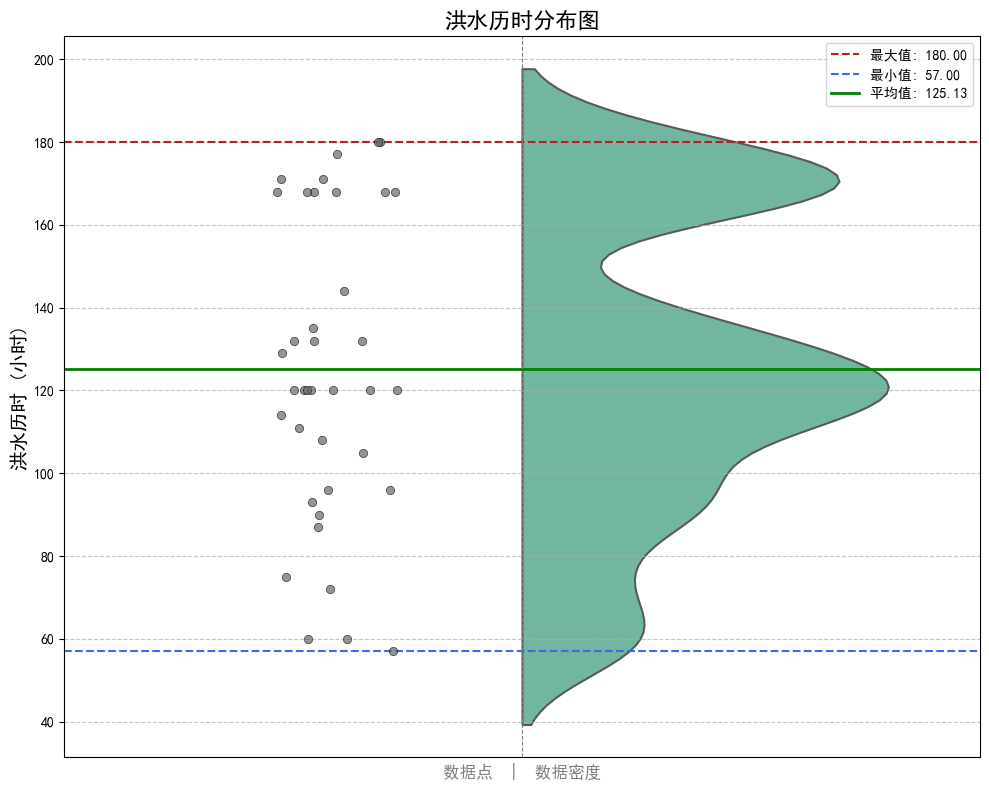


--- 特征: 总净雨量 ---
  最大值: 232.29
  最小值: 7.78
  平均值: 100.80


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\2483006309.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=data, ax=ax, palette=palette, inner=None,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\2483006309.py:97: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


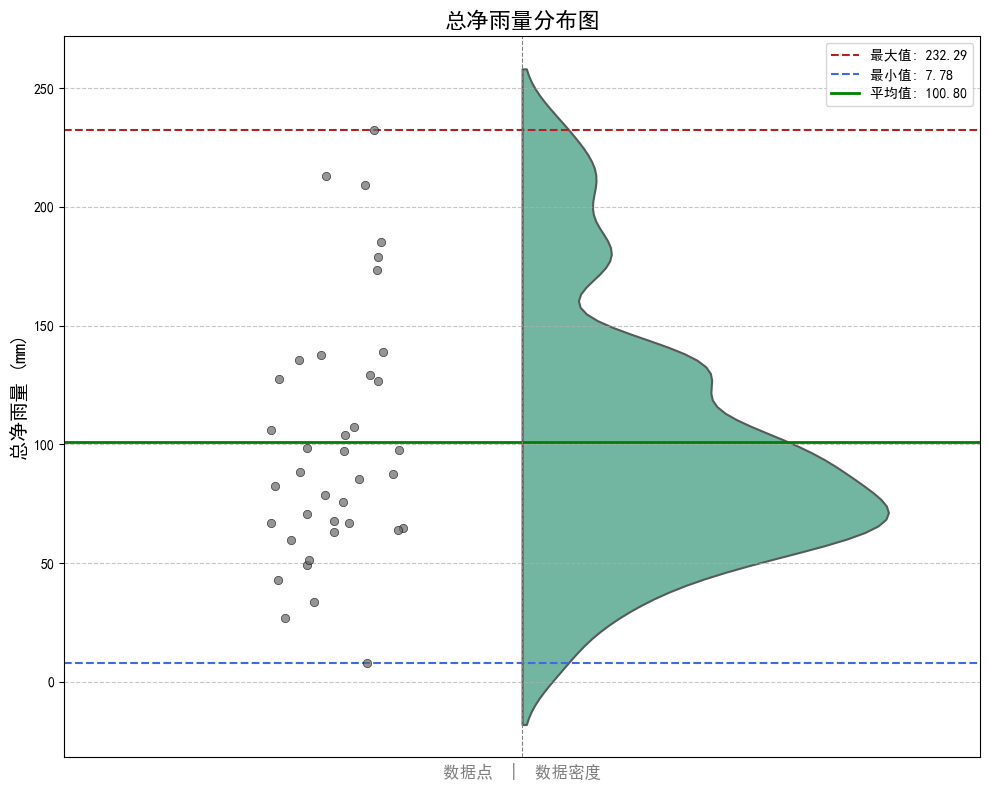


--- 特征: 洪峰雨峰延迟 ---
  最大值: 39.00
  最小值: 0.00
  平均值: 8.92


C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\2483006309.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=data, ax=ax, palette=palette, inner=None,
C:\Users\Administrator\AppData\Local\Temp\ipykernel_6864\2483006309.py:97: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.set_xticks([])


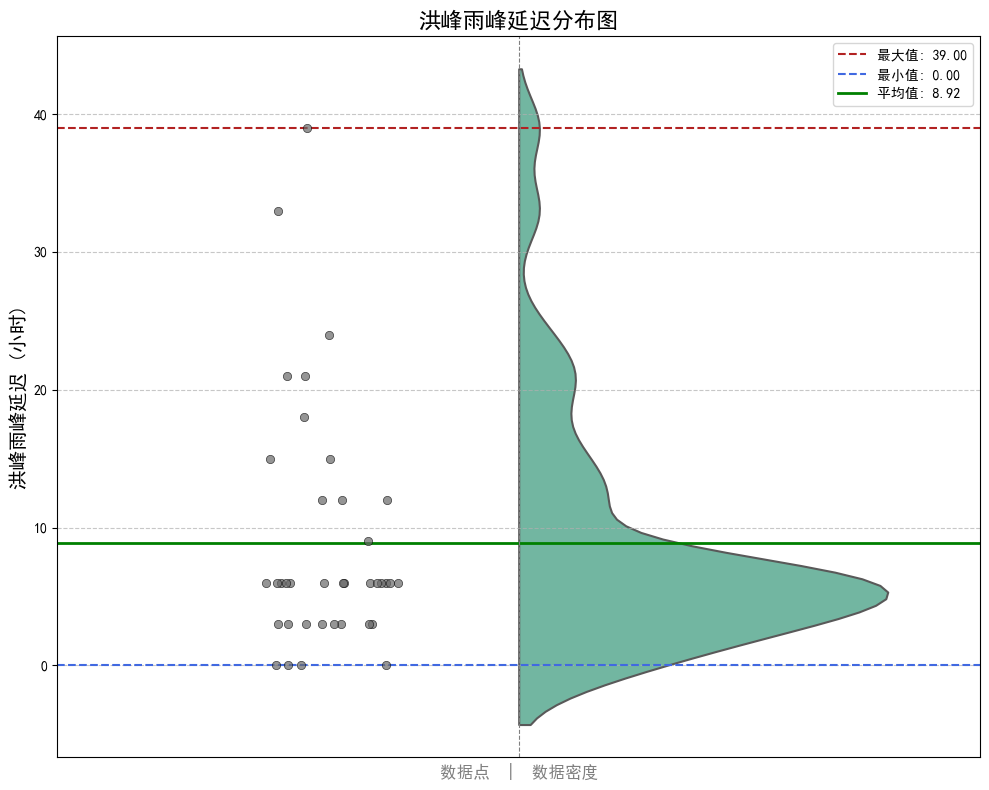

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import seaborn as sns
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 全局常量 ---
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 主要功能函数：数据预处理 (与之前相同) ---
def process_and_analyze_event(csv_filepath):
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(csv_filepath, encoding=enc)
                break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None

    time_col = '时间'; net_rain_col = '泰森多边形面雨量'; direct_runoff_col = '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None

    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    
    if np.sum(net_rain) < 1e-6: return None
    runoff_indices = np.where(direct_runoff > 1e-6)[0]
    if len(runoff_indices) < 2: return None
    runoff_duration_hours = (runoff_indices[-1] - runoff_indices[0] + 1) * DELTA_T_HOURS
    
    peak_flow = np.max(direct_runoff)
    if peak_flow < 1e-6: return None
    t_peak_flow_idx = np.argmax(direct_runoff)
    
    runoff_volume_m3 = np.sum(direct_runoff) * delta_t_seconds
    total_net_rain = np.sum(net_rain)
    t_peak_rain_idx = np.argmax(net_rain)
    lag_time_hours = (t_peak_flow_idx - t_peak_rain_idx) * DELTA_T_HOURS

    return {
        "文件名": os.path.basename(csv_filepath),
        "洪峰流量": peak_flow,
        "洪量": runoff_volume_m3,
        "洪水历时": runoff_duration_hours,
        "总净雨量": total_net_rain,
        "洪峰雨峰延迟": lag_time_hours
    }

# --- 修改后的绘图函数：雨云图，增加统计值标注 ---
def plot_raincloud(data, feature_name, unit, palette="Set2", 
                   max_val=None, min_val=None, mean_val=None):
    """
    绘制单个水文特征的雨云分布图，并标注最大、最小、平均值。
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # --- 1. 绘制散点图和半边小提琴图 (与之前推荐版本相同) ---
    sns.stripplot(y=data, ax=ax, jitter=0.2, size=6, alpha=0.7, color="dimgray",
                  linewidth=0.5, edgecolor='black')
    for collection in ax.collections:
        x, y = collection.get_offsets().T
        new_x = -0.2 + (np.random.rand(len(x)) * 0.15 - 0.075)
        collection.set_offsets(np.c_[new_x, y])

    sns.violinplot(y=data, ax=ax, palette=palette, inner=None, 
                   linewidth=1.5, bw_adjust=0.5)
    for collection in ax.collections:
        if tuple(collection.get_facecolor()[0][:3]) != tuple(sns.color_palette(["dimgray"])[0]):
            path = collection.get_paths()[0]
            vertices = path.vertices
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    # --- 2. 标注统计值 ---
    if max_val is not None:
        ax.axhline(y=max_val, color='firebrick', linestyle='--', linewidth=1.5, label=f'最大值: {max_val:.2f}')
    if min_val is not None:
        ax.axhline(y=min_val, color='royalblue', linestyle='--', linewidth=1.5, label=f'最小值: {min_val:.2f}')
    if mean_val is not None:
        ax.axhline(y=mean_val, color='green', linestyle='-', linewidth=2, label=f'平均值: {mean_val:.2f}')
    
    # --- 3. 美化和调整 ---
    ax.set_xlim(-0.5, 0.5)
    ax.set_xticks([])
    ax.set_xlabel("数据点  |  数据密度", fontsize=12, color='gray')
    ax.set_ylabel(f"{feature_name} ({unit})", fontsize=14)
    ax.set_title(f'{feature_name}分布图', fontsize=16)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    
    # 显示图例
    ax.legend()
    
    plt.tight_layout()
    plt.show()


# --- 主程序 ---
if __name__ == "__main__":
    # 1. 定义数据源
    data_folder = "data_source/" 
    
    # 2. 获取所有CSV文件列表
    try:
        csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
        if not csv_files: exit()
        print(f"找到 {len(csv_files)} 个CSV文件，将进行处理...")
    except FileNotFoundError: exit()

    # 3. 遍历所有文件，计算并收集所有事件的特征
    all_features_data = [d for d in [process_and_analyze_event(f) for f in csv_files] if d]
    if not all_features_data: exit()
        
    # 4. 将结果转换为Pandas DataFrame
    features_df = pd.DataFrame(all_features_data)
    print("\n所有有效洪水事件的水文特征计算完成。")
    
    # 5. 定义要绘制的特征及其标签和单位
    features_to_plot = {
        "洪峰流量": r'$m^3/s$',
        "洪量": r'$\times 10^6\ m^3$',
        "洪水历时": "小时",
        "总净雨量": "mm",
        "洪峰雨峰延迟": "小时"
    }

    # 6. 循环为每个特征计算统计值、打印并绘图
    print("\n--- 正在生成各水文特征的分布图及统计值 ---")
    for feature, unit in features_to_plot.items():
        plot_data = features_df[feature].dropna()
        
        if plot_data.empty:
            print(f"\n特征 '{feature}' 没有有效数据，无法绘图。")
            continue
            
        # 对洪量数据进行缩放
        if feature == "洪量":
            plot_data = plot_data / 1e6
        
        # --- 计算统计值 ---
        max_value = plot_data.max()
        min_value = plot_data.min()
        mean_value = plot_data.mean()

        # --- 打印统计值 ---
        print(f"\n--- 特征: {feature} ---")
        print(f"  最大值: {max_value:.2f}")
        print(f"  最小值: {min_value:.2f}")
        print(f"  平均值: {mean_value:.2f}")
        
        # --- 调用绘图函数，并传入统计值 ---
        plot_raincloud(
            data=plot_data, 
            feature_name=feature, 
            unit=unit,
            max_val=max_value,
            min_val=min_value,
            mean_val=mean_value
        )

### 按照洪峰分类拟合效果最差

找到 38 个CSV文件...
成功预处理 38 场洪水事件。

各类别洪水事件数量:
  Small 洪水: 13 场
  Medium 洪水: 12 场
  Large 洪水: 13 场

--- 正在为组 'small' 优化特征单位线 (13 场) ---
  单位线长度: 49
  使用权重: 平滑=0.1, 单峰罚=100.0
  优化成功

--- 正在为组 'medium' 优化特征单位线 (12 场) ---
  单位线长度: 51
  使用权重: 平滑=0.5, 单峰罚=500.0
  优化成功

--- 正在为组 'large' 优化特征单位线 (13 场) ---
  单位线长度: 55
  使用权重: 平滑=1.0, 单峰罚=1000.0
  优化成功

--- 类别 'Small' 拟合效果最差的三场洪水 ---


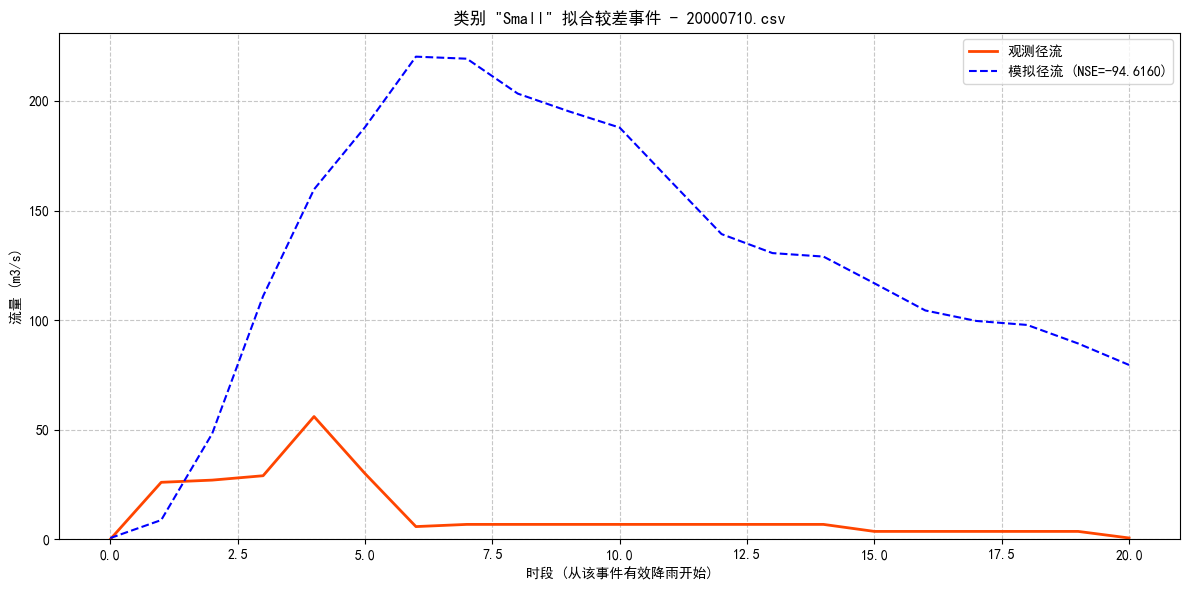

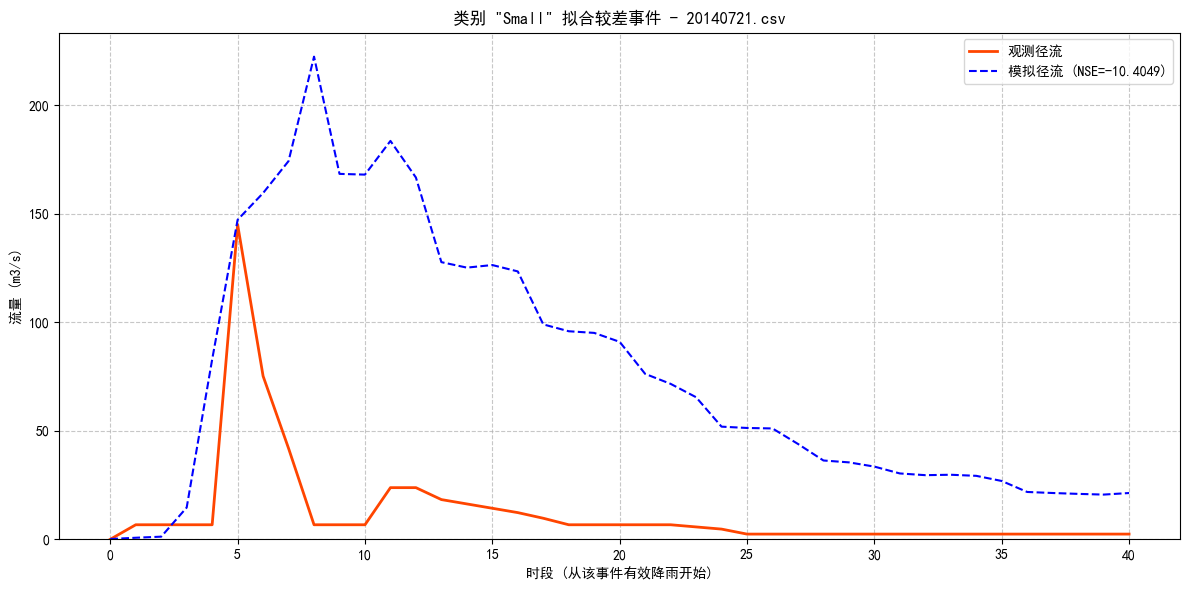

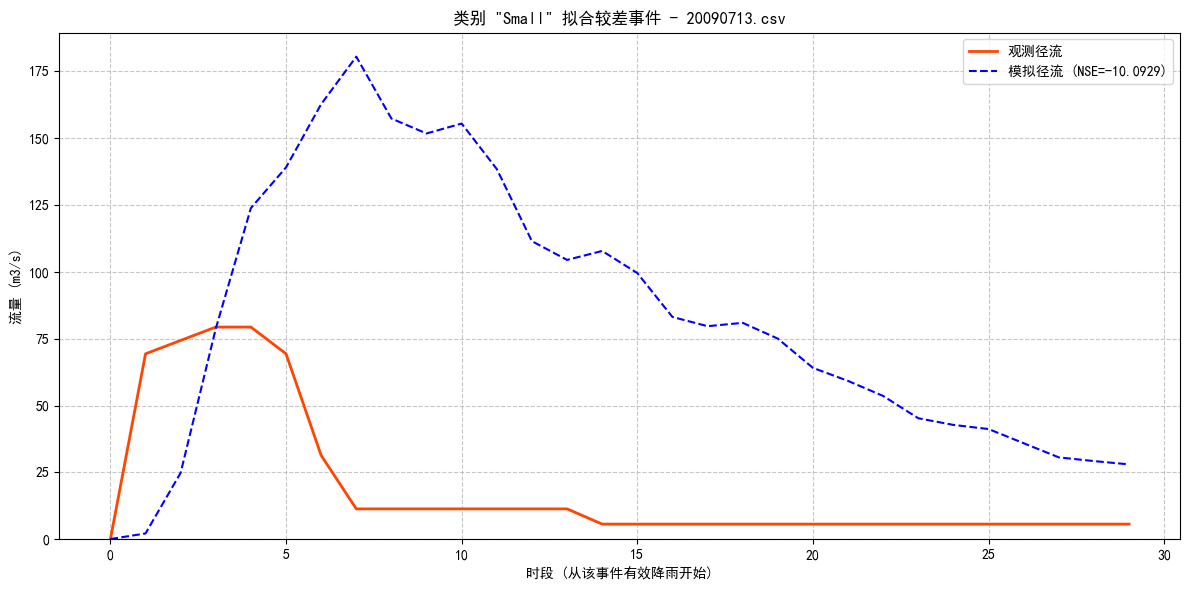


--- 类别 'Medium' 拟合效果最差的三场洪水 ---


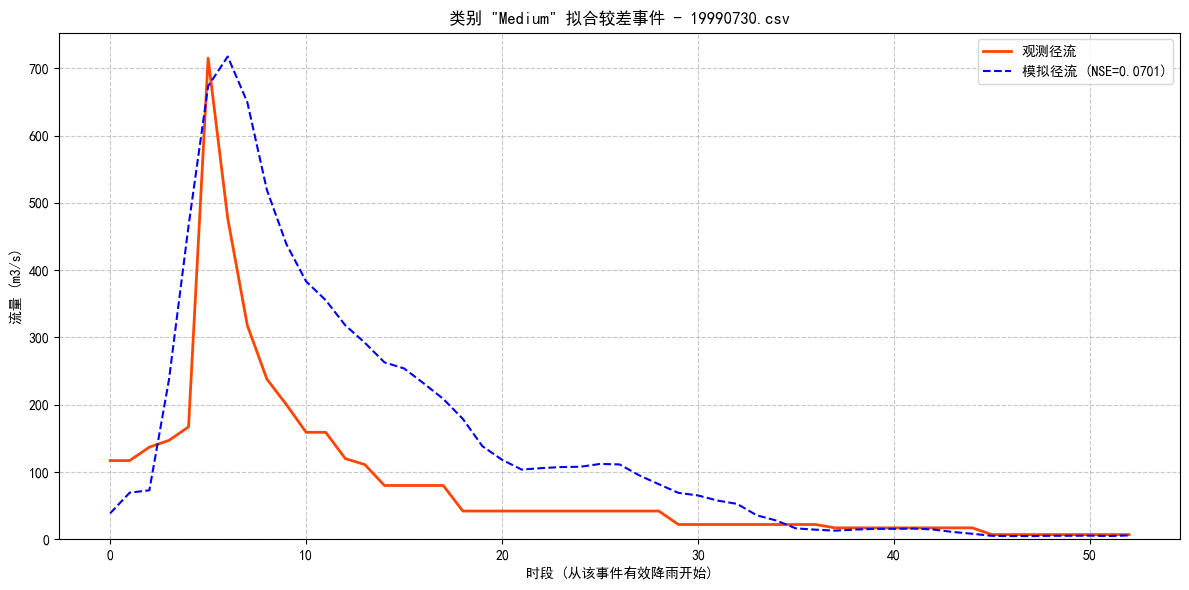

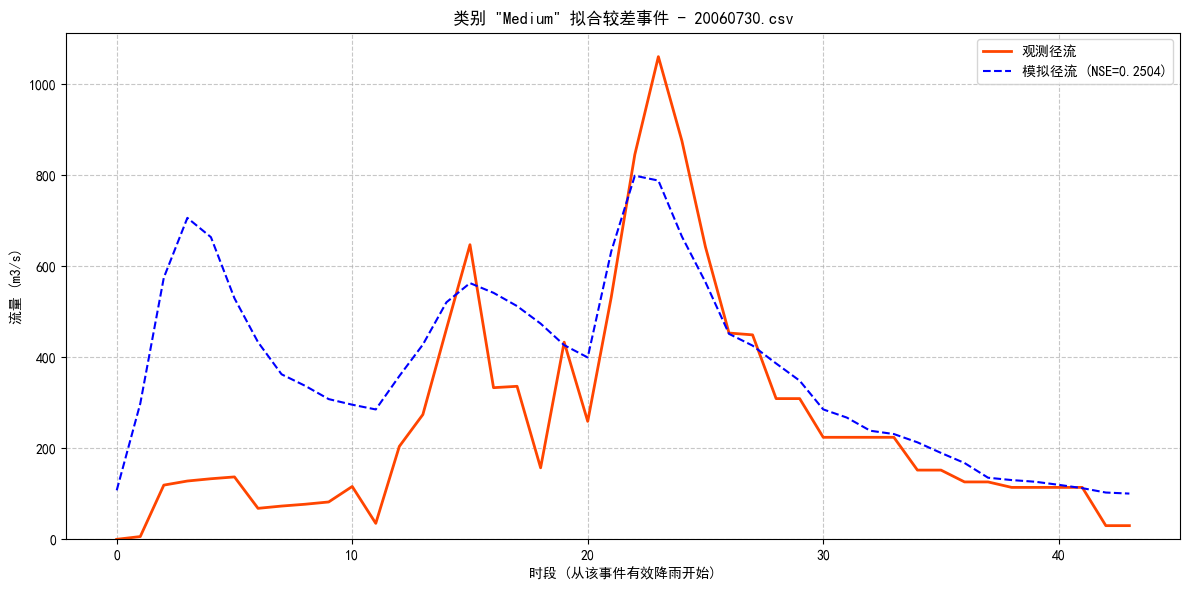

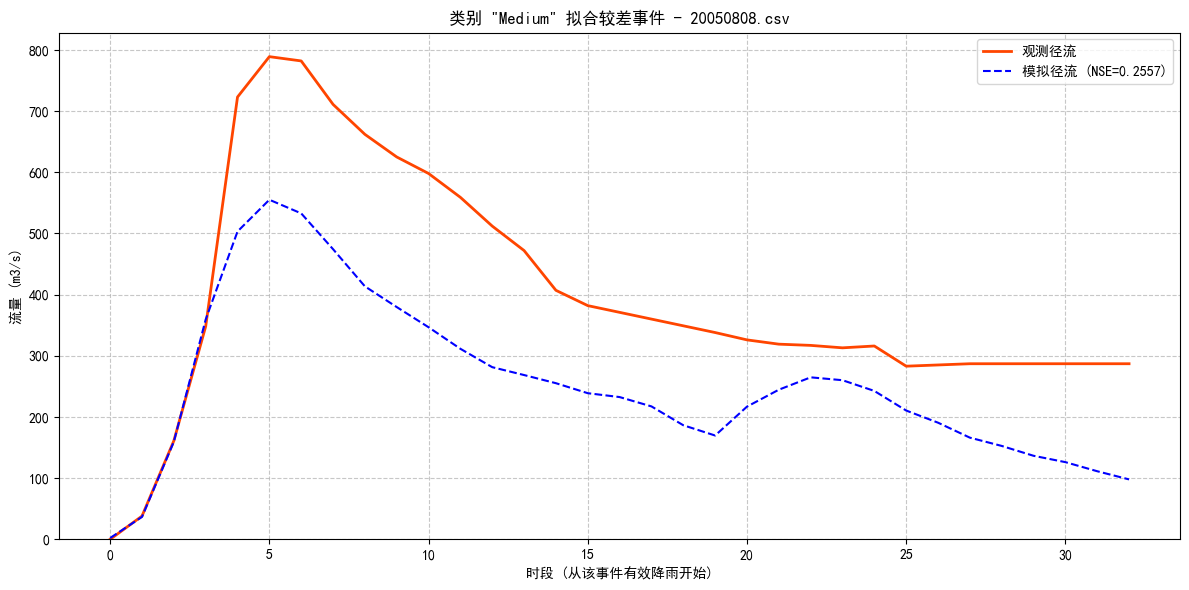


--- 类别 'Large' 拟合效果最差的三场洪水 ---


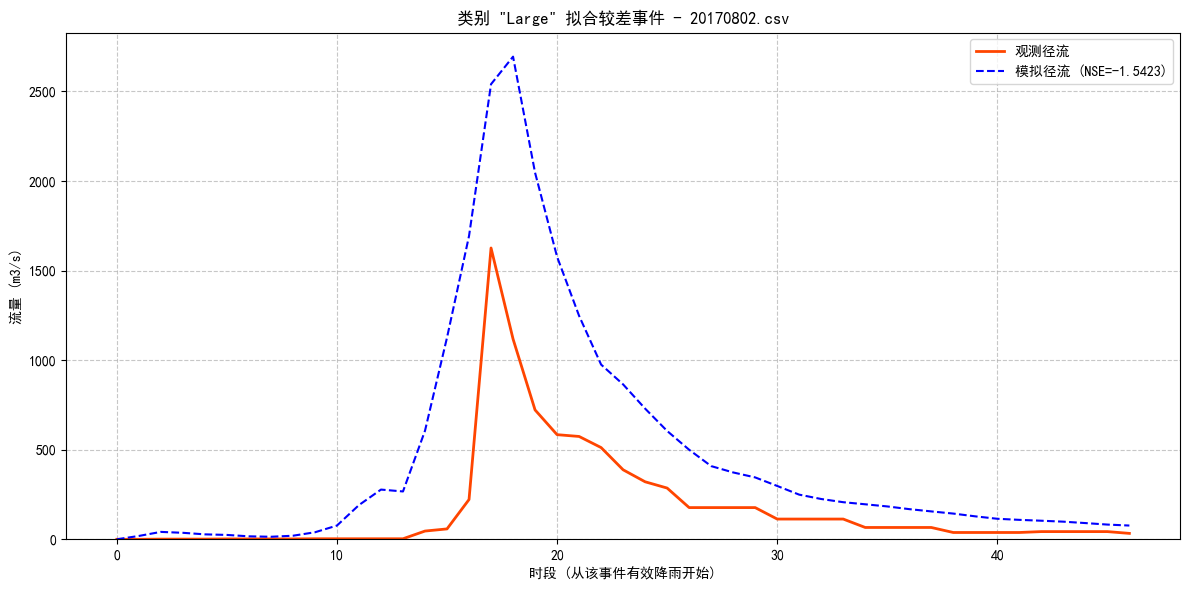

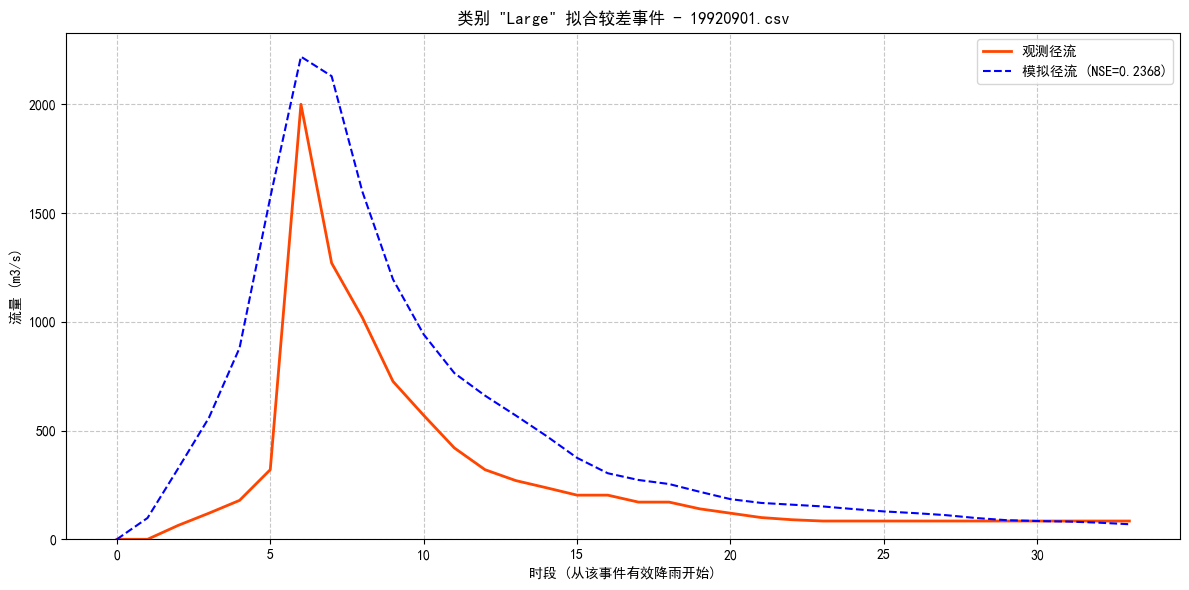

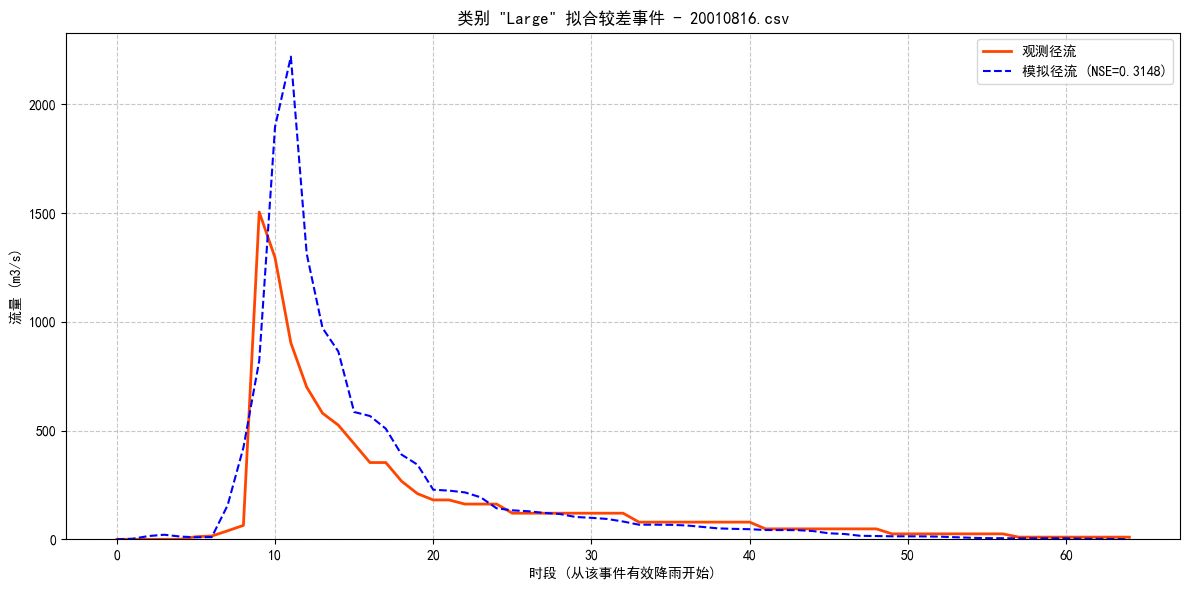

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.font_manager import FontProperties
import os

# --- 配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("中文字体 SimHei 未找到，请确保已安装或修改字体设置。")

R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数：数据预处理 (与之前相同) ---
def preprocess_single_event_data(csv_filepath):
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(csv_filepath, encoding=enc)
                break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None

    time_col = '时间'; net_rain_col = '泰森多边形面雨量'; direct_runoff_col = '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None

    df[net_rain_col] = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0)
    df[direct_runoff_col] = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0)
    net_rain_full_event = df[net_rain_col].values
    direct_runoff_obs_full_event = df[direct_runoff_col].values

    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain_full_event):
        if r_val > 1e-6: first_rain_idx, has_effective_rain = i, True; break
    if not has_effective_rain: return None

    last_rain_idx = len(net_rain_full_event) - 1
    for i in range(len(net_rain_full_event) - 1, first_rain_idx - 1, -1):
        if net_rain_full_event[i] > 1e-6: last_rain_idx = i; break
    
    P_eff_event = net_rain_full_event[first_rain_idx : last_rain_idx + 1]
    m_eff_event = len(P_eff_event)
    if m_eff_event == 0: return None

    Q_obs_eff_event = direct_runoff_obs_full_event[first_rain_idx:]
    l_obs_eff_event = len(Q_obs_eff_event)
    n_event_specific = l_obs_eff_event - m_eff_event + 1
    if n_event_specific <= 0: return None
        
    return {
        "P_eff": P_eff_event, "Q_obs_eff": Q_obs_eff_event,
        "m_eff": m_eff_event, "l_obs_eff": l_obs_eff_event,
        "n_specific": n_event_specific, "filepath": csv_filepath,
        "peak_obs": np.max(Q_obs_eff_event) if len(Q_obs_eff_event) > 0 else 0,
    }

# --- 核心计算函数 (与之前相同) ---
def convolve_uh(P, U, R_UH_val):
    m_p, n_u = len(P), len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh_for_category):
    total_fit_loss = 0
    if len(U_params) != common_n_uh_for_category: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

def optimize_uh_for_group(events_in_group, group_name, weights):
    print(f"\n--- 正在为组 '{group_name}' 优化特征单位线 ({len(events_in_group)} 场) ---")
    if len(events_in_group) < 3:
        print("事件数量过少，跳过优化。")
        return None
    
    n_specifics = [d["n_specific"] for d in events_in_group if d["n_specific"] > 0]
    if not n_specifics: return None
    
    n_uh_group = int(np.max(n_specifics))
    if n_uh_group <= 1: n_uh_group = max(3, n_uh_group if n_uh_group > 0 else 3)
    print(f"  单位线长度: {n_uh_group}")

    data_for_opt_group = []
    for event in events_in_group:
        P_eff, Q_obs_eff, m_eff = event["P_eff"], event["Q_obs_eff"], event["m_eff"]
        target_q_len = m_eff + n_uh_group - 1
        if target_q_len < 0: target_q_len = 0
        Q_obs_for_opt = np.zeros(target_q_len)
        len_to_copy = min(len(Q_obs_eff), target_q_len)
        Q_obs_for_opt[:len_to_copy] = Q_obs_eff[:len_to_copy]
        data_for_opt_group.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt})

    U_initial = np.zeros(n_uh_group)
    bounds = [(0, None) for _ in range(n_uh_group)]
    smoothing, peak_penalty = weights['smoothing_factor'], weights['peak_violation_weight']
    apply_penalty = n_uh_group > 2
    print(f"  使用权重: 平滑={smoothing}, 单峰罚={peak_penalty if apply_penalty else 'N/A'}")

    result_uh = minimize(
        objective_function_multi_event, U_initial,
        args=(data_for_opt_group, R_UH, smoothing, peak_penalty, apply_penalty, n_uh_group),
        method='L-BFGS-B', bounds=bounds,
        options={'disp': False, 'maxiter': 500, 'ftol': 1e-8}
    )
    
    U_optimized = result_uh.x if (result_uh.success or result_uh.status in [0,2]) else None
    status_message = "成功" if (result_uh.success or result_uh.status in [0,2]) else "可能未收敛"
    print(f"  优化{status_message}")
    
    return U_optimized

# --- 主程序 ---
# 1. 数据预处理
data_folder = "data_source/" 
csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
print(f"找到 {len(csv_files)} 个CSV文件...")
all_events_processed_data = [d for d in [preprocess_single_event_data(f) for f in csv_files] if d]
if not all_events_processed_data: exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

# 2. 洪水事件分类
event_peaks = [data['peak_obs'] for data in all_events_processed_data if data['peak_obs'] > 0]
if not event_peaks: exit()
threshold_low = np.percentile(event_peaks, 33.3)
threshold_high = np.percentile(event_peaks, 66.6)
categorized_events = {'small': [], 'medium': [], 'large': []}
for event_data in all_events_processed_data:
    peak = event_data['peak_obs']
    if peak <= threshold_low: categorized_events['small'].append(event_data)
    elif peak <= threshold_high: categorized_events['medium'].append(event_data)
    else: categorized_events['large'].append(event_data)
print("\n各类别洪水事件数量:")
for category, events in categorized_events.items(): print(f"  {category.capitalize()} 洪水: {len(events)} 场")

# 3. 为每个类别推求特征单位线
category_weights = {
    'small':  {'smoothing_factor': 0.1, 'peak_violation_weight': 100.0},
    'medium': {'smoothing_factor': 0.5, 'peak_violation_weight': 500.0},
    'large':  {'smoothing_factor': 1.0, 'peak_violation_weight': 1000.0}
}
optimized_uhs = {}
for category_name, events in categorized_events.items():
    weights = category_weights.get(category_name, {})
    optimized_uhs[category_name] = optimize_uh_for_group(events, category_name, weights)

# 4. 评估并绘制每个类别拟合最差的三场洪水
for category_name, events_in_category in categorized_events.items():
    U_optimized_cat = optimized_uhs.get(category_name)
    if U_optimized_cat is None:
        print(f"\n类别 '{category_name}' 没有可用的特征单位线，跳过评估。")
        continue

    # 计算该类别内所有事件的NSE
    category_event_analysis = []
    for event_data in events_in_category:
        P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
        Q_sim_event_full = convolve_uh(P_event, U_optimized_cat, R_UH)
        Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
        
        nse_event = np.nan
        if len(Q_obs_event_full) > 0 and len(Q_sim_event_compare) == len(Q_obs_event_full):
            mean_obs = np.mean(Q_obs_event_full)
            den_nse = np.sum((Q_obs_event_full - mean_obs)**2)
            if den_nse == 0: nse = 1.0 if np.allclose(Q_sim_event_compare, Q_obs_event_full) else -np.inf
            else: nse = 1 - (np.sum((Q_obs_event_full - Q_sim_event_compare)**2) / den_nse)
            nse_event = nse
        category_event_analysis.append({"filepath": event_data["filepath"], "NSE": nse_event})

    # 按NSE从小到大排序
    category_event_analysis_sorted = sorted(category_event_analysis, 
                                            key=lambda x: x["NSE"] if pd.notna(x["NSE"]) and np.isfinite(x["NSE"]) else float('-inf'))
    
    # 获取拟合最差的三场
    worst_three_events_info = category_event_analysis_sorted[:3]

    print(f"\n--- 类别 '{category_name.capitalize()}' 拟合效果最差的三场洪水 ---")
    if not worst_three_events_info:
        print("  没有可供评估的事件。")
        continue

    for event_info in worst_three_events_info:
        # 从原始数据中找到这个事件的完整数据
        worst_event_data = next((data for data in events_in_category if data["filepath"] == event_info["filepath"]), None)
        if worst_event_data:
            P_worst = worst_event_data["P_eff"]
            Q_obs_worst = worst_event_data["Q_obs_eff"]
            
            Q_sim_worst_full = convolve_uh(P_worst, U_optimized_cat, R_UH)
            Q_sim_worst_plot = Q_sim_worst_full[:len(Q_obs_worst)]
            
            # 绘图
            plt.figure(figsize=(12, 6))
            plt.plot(np.arange(len(Q_obs_worst)), Q_obs_worst, label='观测径流', color='orangered', linewidth=2)
            plt.plot(np.arange(len(Q_sim_worst_plot)), Q_sim_worst_plot, label=f'模拟径流 (NSE={event_info["NSE"]:.4f})', color='blue', linestyle='--')
            plt.title(f'类别 "{category_name.capitalize()}" 拟合较差事件 - {os.path.basename(worst_event_data["filepath"])}')
            plt.xlabel('时段 (从该事件有效降雨开始)')
            plt.ylabel('流量 (m3/s)')
            plt.legend()
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.ylim(bottom=0)
            plt.tight_layout()
            plt.show()